# NOISE, PARTIES AND COMPLAINTS IN SAN FRANCISCO
# Where it Happens, When and Who is Responsible. 

This notebook asseses San Francisco's nighttime loudness by analyzing 311 call data and combining it with geospatial data and noise permit data, each drawn from the City's open data portal <a href='https://datasf.org/opendata/'>DataSF</a>. 

We seek to answer three main questions: 

* Which neighborhoods of San Francisco are the loudest? 
* Which times of day and month are loudest?
* Which specific places have the most noise reports? (And who are the people responsible for all this noise?)

**About the Notebook**

While this analysis is primarily informative, we believe that it could lead to many questions worth pursuing. This notebook identifies the specific coordinates and addresses which triggered the most complaints from citizens between mid 2016 and 2019. Further research would likely reveal the identities and motives of the individuals who manage those properties. Interestingly, we also found that none of the properties which were most often implicated in noise reports in the past year was in possession of a night noise permit by the City. Therefore, per the San Francisco Police Code, they were acting illegally.  

**About the Data**

<a href='https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6/data'>311 Cases</a>: Lists and locates complaints and crimes reported to 311 operatives since early 2008. The dataframe is updated regularly. This notebook only analyses data relating to noise and loud events. 

<a href='https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h'>Analysis Neighborhood</a>: Codifies and locates 41 SF neighborhoods by grouping 2010 Census tracts. The dataframe was compiled by the Department of Public Health and the Mayor’s Office of Housing and Community Development. 

<a href='https://data.sfgov.org/Housing-and-Buildings/Night-Noise-Permits/e7pr-36bt/data'>Night Noise Permits</a>: Codifies and locates night noise permits issued by the City as of July 2019. The dataframe was updated daily as of March 2020.  

______________________________________________________________________________________________

## SET UP

### Importing Modules

The visualizations in this notebook rely primarily on the Pandas, GeoPandas and MatPlotLib libraries. We also install the Seaborn statistical data visualization module to facilitate the plotting of color-coded graphs. 

In [2]:
import pandas as pd
import geopandas as gdp
import vega
import descartes
import seaborn as sns

pd.options.display.max_rows = None

%matplotlib inline
import matplotlib.pyplot as plt

import altair as alt
from vega_datasets import data

We set up a portable path environment by creating a DATA_DIR environment variable. We also stored the path to the 'raw' and 'processed' directories in data. 

In [3]:
import os
data_dir = os.environ['DATA_DIR']   # path to data/
rawdata_dir = data_dir + '/raw/'
processeddata_dir = data_dir + '/processed/'

### Importing Data

We **(temporarily)** load of the filtered set of data from the 311 DataSF dataframe into a csv readable format. To simplify further analysis of Time Series data, we convert date and time fields to DateTime objects. 

In [4]:
noise_comps = pd.read_csv(os.path.join(rawdata_dir, '311_Cases.csv'), parse_dates=['Opened', 'Closed', 'Updated'])

Here's a peek at our data frame right now:

In [6]:
noise_comps.head(3)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
0,11914612,2020-01-08 04:49:02,2020-01-09 06:00:14,2020-01-09 06:00:14,Closed,Accepted - Noise informational reports are clo...,Noise Report Queue,Noise Report,other_excessive_noise,Noise Report - other_excessive_noise,"316 LAWTON ST, SAN FRANCISCO, CA, 94122",LAWTON ST,7.0,Inner Sunset,TARAVAL,37.758553,-122.466286,"(37.75855255, -122.46628571)",Web,NaN
1,9209249,2018-06-30 20:35:38,2018-06-30 21:07:00,2018-06-30 21:07:00,Closed,Comment Noted - Please report to SFPD by calli...,311 Supervisor Queue,Noise Report,Noise Issue,Other,"601 CLAYTON ST, SAN FRANCISCO, CA, 94117",CLAYTON ST,5.0,Haight Ashbury,PARK,37.769657,-122.448758,"(37.76965675, -122.44875848)",Mobile/Open311,NaN
2,9209125,2018-06-30 19:36:58,2018-06-30 19:46:00,2018-06-30 19:46:00,Closed,Comment Noted - Please contact Non Emergency p...,311 Supervisor Queue,Noise Report,Noise Issue,Other,"390 FRANCONIA ST, SAN FRANCISCO, CA, 94110",FRANCONIA ST,9.0,Peralta Heights,INGLESIDE,37.743768,-122.408280,"(37.7437682, -122.4082804)",Web,NaN


## DATA ANALYSIS

### Which Neighborhoods received the most complaints?

#### Sorting and Indexing Dataframe
We select the top 10 neighborhoods that received the highest count of complaints, then sort them in ascending order. 

In [7]:
neighborhoods = noise_comps.groupby(by="Neighborhood").CaseID.count().reset_index()
sorted_neighborhoods = neighborhoods.sort_values(by=['CaseID','Neighborhood'], ascending=False)
sorted_neighborhoods.columns = ['Neighborhood', 'Complaints']

**Note**: In order to capture the top 10 in the dataframe, we first sort in descending order. Then we select the sample and reverse. 

In [9]:
top_neighborhoods = sorted_neighborhoods.head(10).sort_values(by='Complaints', ascending=True)
top_neighborhoods

,Neighborhood,Complaints
36,Haight Ashbury,153
77,Pacific Heights,161
15,Civic Center,180
75,Outer Richmond,182
65,Mission Dolores,254
105,Tenderloin,310
54,Lower Nob Hill,316
76,Outer Sunset,365
97,South of Market,720
63,Mission,770


#### Plotting neighborhood data

In plotting the data, we choose to create a custom color range which may be easily applied to any plot kind.The custom range allows us to maintain the same neighborhood color values for the geomap (next section) as for the bar graph. 

In [10]:
# Setting neighborhood color palette

color_range = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
palette = sns.color_palette(color_range)

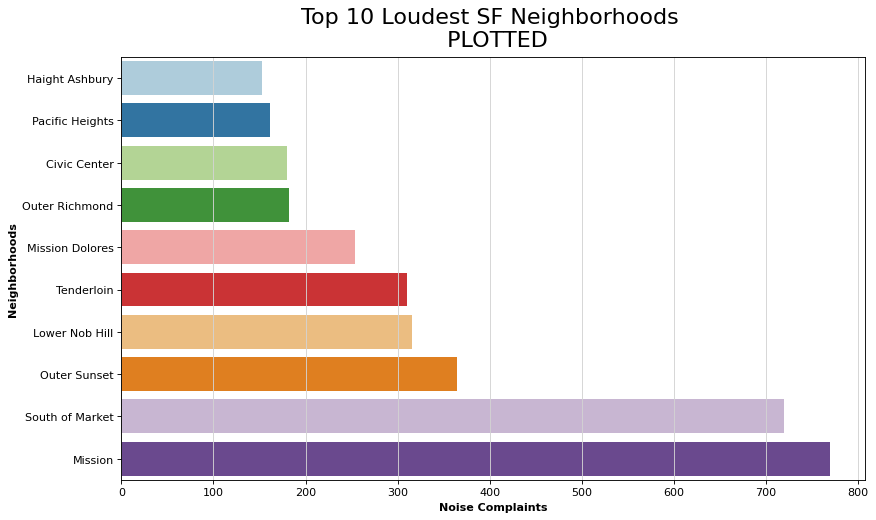

In [11]:
# Setting plot size and background and edge colors
plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

#Plotting bar graph
plotted = sns.barplot(x='Complaints', y='Neighborhood', data=top_neighborhoods, palette=palette)

#Setting graph properties
plt.xlabel('Noise Complaints', fontweight='bold')
plt.ylabel('Neighborhoods', fontweight='bold')
plt.grid(axis='x', color='lightgrey')   # sets grid
plt.title('Top 10 Loudest SF Neighborhoods \n PLOTTED', fontsize=20, verticalalignment='bottom')   # sets title

# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/nhoods_plotted')
plt.show()

The neighborhood with the most noise reports between February 2010 and March 2020 is the Mission, with nearly 800 noise reports. It is followed closely by South of Market. Outer Sunset ranks a distant third. The bars in the plot above are color coded to coincide with the map, below.

#### Mapping neighborhood data

To ensure a fair reproduction of the mapped data, we clear null values from the dataframe. 

In [12]:
# Cleaning data
noise_comps = noise_comps.rename(columns={'Point' : 'location'})
noise_comps = noise_comps[noise_comps.location != '(0.0, 0.0)']

We use **shapely.geometry**, as suggested, to convert coordinates into readable geospatial geometry points.

In [13]:
from shapely.geometry import Point
import re

def point_from_str(location):
    lat, lon = map(float, re.findall(r'(-?\d+\.\d+)', location))
    return (lon, lat)

# Create a coordinates column with proper lon/lat tuples
noise_comps['coordinates'] = noise_comps.location.apply(point_from_str)
# Convert to Geopandas Points
noise_comps['coordinates'] = noise_comps['coordinates'].apply(Point)

Once both dataframes are clean and ready for use, we read them in as GeoPandas dfs.

In [14]:
comps_gdp = gdp.GeoDataFrame(noise_comps, geometry='coordinates')
shapes = gdp.read_file('zip://Analysis Neighborhoods.zip')

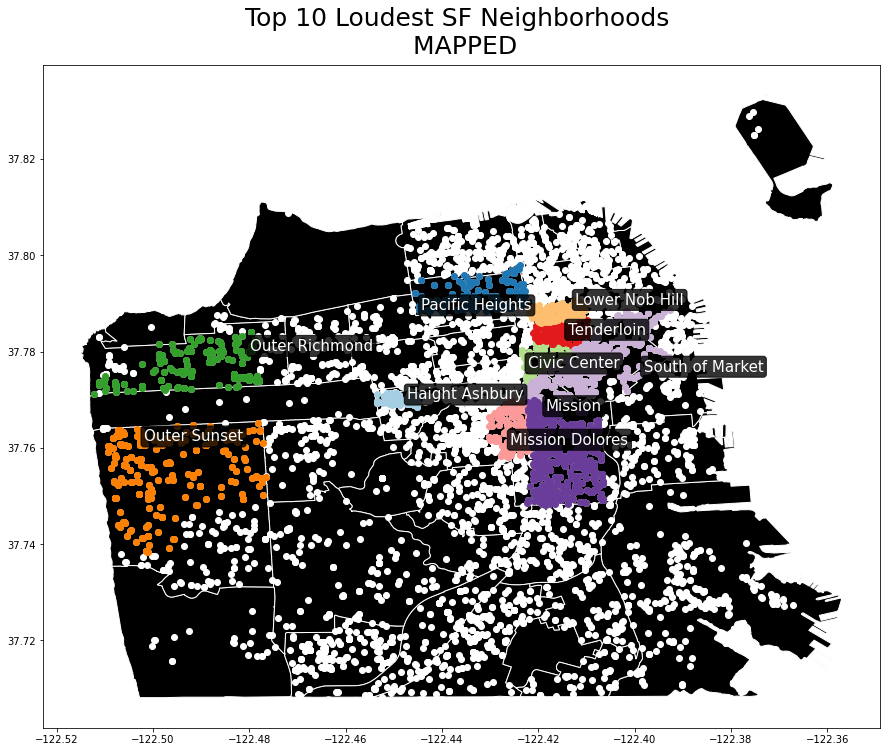

In [15]:
# Mapping the main frame – map of SF neighborhoods
ax = shapes.plot(color='k', edgecolor='white', figsize=(15, 15))
plt.title('Top 10 Loudest SF Neighborhoods \n MAPPED', fontsize=25, verticalalignment='bottom')   # sets title

# Mapping data as subplot
mapped = comps_gdp.plot(ax=ax, color='white')

# Styling text box overlays
bbox_props = dict(boxstyle="round, pad=0.2", fc="black", alpha=0.8)

# Mapping colored neighborhood overlays
def map_neighborhoods(dataset, colors):
    n = 0
    for neighborhood in dataset.Neighborhood:
        data = comps_gdp[comps_gdp.Neighborhood == neighborhood]
        data.plot(
            ax=ax, color=colors[n]).annotate(
            neighborhood, xy=(data.Longitude.iloc[100], 
                              data.Latitude.iloc[100]),   # arbitrary lon,lat values to set labels
            color='white',
            fontsize = 15,
            bbox=bbox_props   # sets round boxes around text
        )
        n += 1   # sets colors by increment
map_neighborhoods(top_neighborhoods, color_range)

# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/nhoods_mapped')

plt.show()

Each dot in the plot above represents a noise report called into 311 between February 2010 and March 2020. By mapping these points, we can see more clearly that noise complaints are concentrated primarily in downtown neighborhoods, rather than in residential areas around the periphery of the city. Notably, this means that the concentration of noise reports likely reflects the population. If we want to explore this topic further, we would want to measure noise reports per-person.

### When are most complaints filed?

#### Extracting DateTime fields

We extract and add month of year and hour of day to the noise complaints dataframe. Then, we convert numerical months to short month names (e.g. from 1 to 'Jan'). We pass a categorical variable 'months' to ensure the plot retains the correct x-axis order. 

In [80]:
import calendar

# Extracting the month
noise_comps['Month'] = pd.DatetimeIndex(noise_comps['Opened']).month
months = noise_comps.groupby(by="Month").agg({'CaseID' : 'count'}).reset_index()

# Extracting the day of month
noise_comps['Day'] = pd.DatetimeIndex(noise_comps['Opened']).day

# Extracting the hour of day
noise_comps['Hour'] = pd.DatetimeIndex(noise_comps['Opened']).hour
hours = noise_comps.groupby(by="Hour").agg({'CaseID' : 'count'}).reset_index()

#### Plotting Time Series data

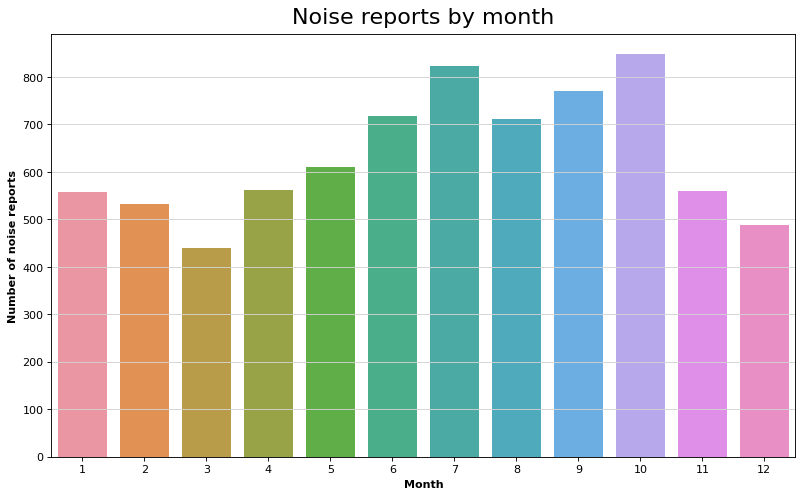

In [36]:
# Setting plot size and background and edge colors

plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

#Plotting bar graph
plotted = sns.barplot(x='Month', y='CaseID', data=months)

#Setting graph properties
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Number of noise reports', fontweight='bold')
plt.grid(axis='y', color='lightgrey')   # sets grid
plt.title('Noise reports by month', fontsize=20, verticalalignment='bottom')   # sets title

# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/months')
plt.show()

The plot above shows the number of noise reports to the city for each month during this time period. What stands out here is that July and October have the most noise reports. 

Now, let's see how noise reports vary by time of day.

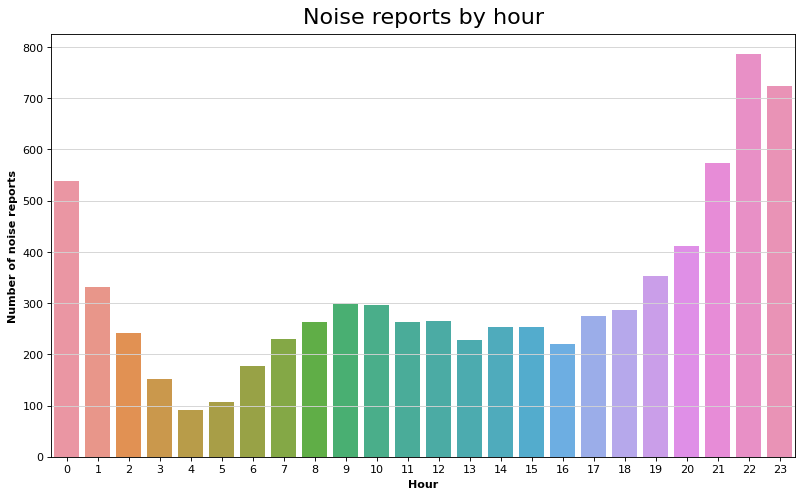

In [38]:
# Setting plot size and background and edge colors

plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

#Plotting bar graph
plotted = sns.barplot(x='Hour', y='CaseID', data=hours)

#Setting graph properties
plt.xlabel('Hour', fontweight='bold')
plt.ylabel('Number of noise reports', fontweight='bold')
plt.grid(axis='y', color='lightgrey')   # sets grid
plt.title('Noise reports by hour', fontsize=20, verticalalignment='bottom')   # sets title

# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/hours')
plt.show()

The pattern above is not very surprising. We see that noise reports peak during evening around 10 or 11 p.m.

Now, let's see how complaints about noise vary by hour, seasonally.

In [82]:
# Calculating the hour with the most complaints for each month

months_hours = noise_comps.groupby(by=['Month', 'Hour']).CaseID.count().reset_index()

# Recoding months_hours into seasons

def seasons(month):
    if month == 12:
        return "winter"
    elif month == 1:
        return "winter"
    elif month == 2:
        return "winter"
    elif 3 <= month <= 5:
        return "spring"
    elif 6 <= month <= 8:
        return "summer"
    elif 9 <= month <= 11:
        return "fall"
    
months_hours['Season'] = months_hours['Month'].apply(seasons)

<Figure size 960x560 with 0 Axes>

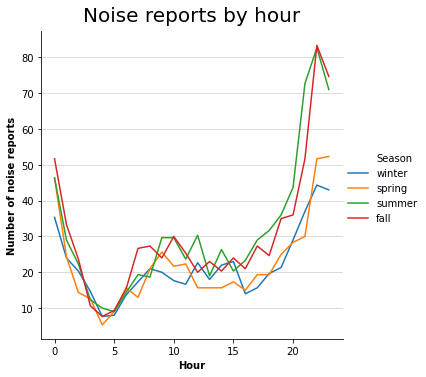

In [79]:
# Setting plot size and background and edge colors

plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

#Plotting line plot
plotted = sns.relplot(x='Hour', y='CaseID', data=months_hours, kind="line", hue='Season', ci=None)

#Setting graph properties
plt.xlabel('Hour', fontweight='bold')
plt.ylabel('Number of noise reports', fontweight='bold')
plt.grid(axis='y', color='lightgrey')   # sets grid
plt.title('Noise reports by hour', fontsize=20, verticalalignment='bottom')   # sets title

# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/seasons')
plt.show()

The plot above shows clear seasonal variation in the times of day when noise complaints peak. What stands out here is that fall and summer appear to be noisier than winter and fall, especially during those key, late night hours, when the gap between the two really shows.

Finally, let's take a closer look at July and October, the months that are likely driving this trend.

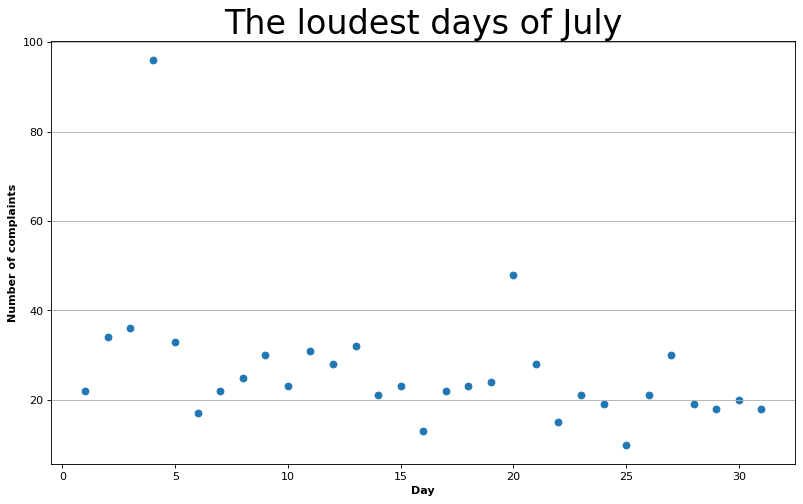

In [93]:
# Filtering just to the month of July
july = noise_comps[noise_comps.Month == 7]

# Counting complaints on each day of July
july_days = july.groupby(by="Day").agg({'CaseID' : 'count'}).reset_index()

# Setting plot size and background and edge colors
plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

# Building scatter plot of July
scatter = plt.scatter(x='Day', y='CaseID', data=july_days)

#Setting graph properties
plt.xlabel("Day", fontweight='bold')
plt.ylabel("Number of complaints", fontweight='bold')
plt.grid(axis='y')   # sets grid
plt.title('The loudest days of July', fontsize=30)   # sets title

# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/july_scatter')

plt.show()

No surprises here. It turns out people like to make a lot of noise (and probably, set off fireworks) on the Fourth of July. It's a clear outlier in the plot above.

Now, let's check out October.

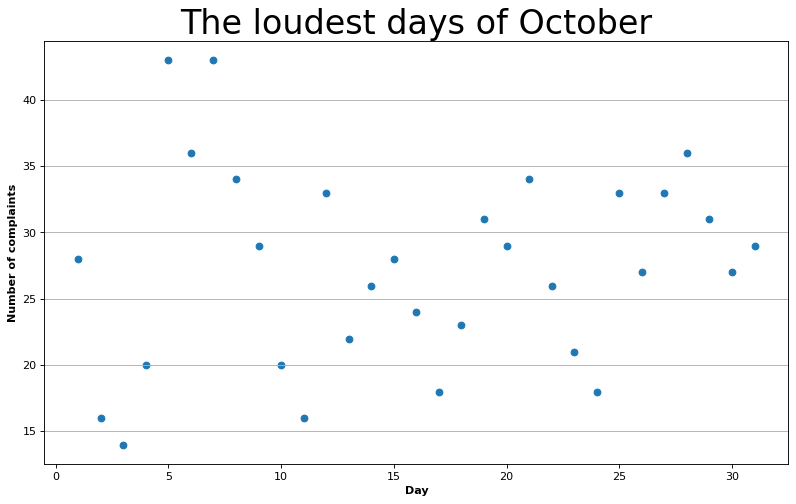

In [94]:
# Filtering just to the month of July
october = noise_comps[noise_comps.Month == 10]

# Counting complaints on each day of July
october_days = october.groupby(by="Day").agg({'CaseID' : 'count'}).reset_index()

# Setting plot size and background and edge colors
plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

# Building scatter plot of July
scatter = plt.scatter(x='Day', y='CaseID', data=october_days)

#Setting graph properties
plt.xlabel("Day", fontweight='bold')
plt.ylabel("Number of complaints", fontweight='bold')
plt.grid(axis='y')   # sets grid
plt.title('The loudest days of October', fontsize=30)   # sets title

# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/october_scatter')

plt.show()

This is a pretty interesting plot. I anticipated that the number of noise reports would peak around Halloween, or perhaps around Columbus Day. Instead, the peak is October 5 and October 7. Perhaps this has something to do with [Fleet Week](https://www.sftourismtips.com/fleet-week-san-francisco.html).

### Who is responsible?

#### Filtering geospatial data

As we did above, we convert coordinates into readable geospatial geometry points. Then, we create a layered map displaying the main frame of SF, the comprehensive data of all complaints, and finally the top 10 recepients of complaints (labeled with count). 

In [96]:
# Filtering and sorting loudest locations 
top_noises = noise_comps.groupby(by=['location', 'Address', 'Latitude', 'Longitude']).CaseID.count().reset_index().sort_values(
    by=['CaseID'], ascending=False).head(10)

# Create a coordinates column with proper lon/lat tuples
top_noises['coordinates'] = top_noises.location.apply(point_from_str)

# Convert to Geopandas Points
top_noises['coordinates'] = top_noises['coordinates'].apply(Point)
top_noises_gdp = gdp.GeoDataFrame(top_noises, geometry='coordinates')

top_noises_gdp.sort_values(by='CaseID', ascending=False)

,location,Address,Latitude,Longitude,CaseID,coordinates
2184,"(37.76142883, -122.50183868)","1360 43RD AVE, SAN FRANCISCO, CA, 94122",37.761429,-122.501839,89,POINT (-122.50184 37.76143)
326,"(37.72041321, -122.45933533)","1017 CAPITOL AVE, SAN FRANCISCO, CA, 94112",37.720413,-122.459335,77,POINT (-122.45934 37.72041)
4269,"(37.7797, -122.42)","475 VAN NESS AVE, SAN FRANCISCO, CA, 94102",37.779700,-122.420000,47,POINT (-122.42000 37.77970)
1037,"(37.74295807, -122.42730713)","224 DAY ST, SAN FRANCISCO, CA, 94131",37.742958,-122.427307,27,POINT (-122.42731 37.74296)
291,"(37.7197876, -122.46476746)","212 GARFIELD ST, SAN FRANCISCO, CA, 94132",37.719788,-122.464767,16,POINT (-122.46477 37.71979)
2469,"(37.76391602, -122.47260284)","1368 IRVING ST, SAN FRANCISCO, CA, 94122",37.763916,-122.472603,15,POINT (-122.47260 37.76392)
146,"(37.71539307, -122.45230865)","172 CAINE AVE, SAN FRANCISCO, CA, 94112",37.715393,-122.452309,15,POINT (-122.45231 37.71539)
4651,"(37.7823406, -122.4155348)","168 HYDE ST, SAN FRANCISCO, CA, 94102",37.782341,-122.415535,14,POINT (-122.41553 37.78234)
2034,"(37.760543, -122.488936)","1431 30TH AVE, SAN FRANCISCO, CA, 94122",37.760543,-122.488936,12,POINT (-122.48894 37.76054)
1821,"(37.75855255, -122.46628571)","316 LAWTON ST, SAN FRANCISCO, CA, 94122",37.758553,-122.466286,10,POINT (-122.46629 37.75855)


Let's take a closer look at what some of these locations are. 

* 1360 43RD AVE looks like it's [a park for children](https://groundplaysf.org/projects/playland-at-43rd-avenue/)
* 1017 CAPITOL AVE looks like it's [just somebody's house](https://www.google.com/maps/place/1017+Capitol+Ave,+San+Francisco,+CA+94112/@37.7204826,-122.4599296,19.44z/data=!4m5!3m4!1s0x808f7c32954cc5ff:0x4446c4517cf3ef65!8m2!3d37.7204133!4d-122.4594401)
* 475 VAN NESS AVE is [the San Francisco Opera!](https://www.google.com/maps/place/475+Van+Ness+Ave,+San+Francisco,+CA+94102/@37.7797374,-122.4210191,19.08z/data=!4m5!3m4!1s0x80858099bbc39a33:0xba211afda2477fe!8m2!3d37.7798152!4d-122.4203556)

What an unexpected mix of places.

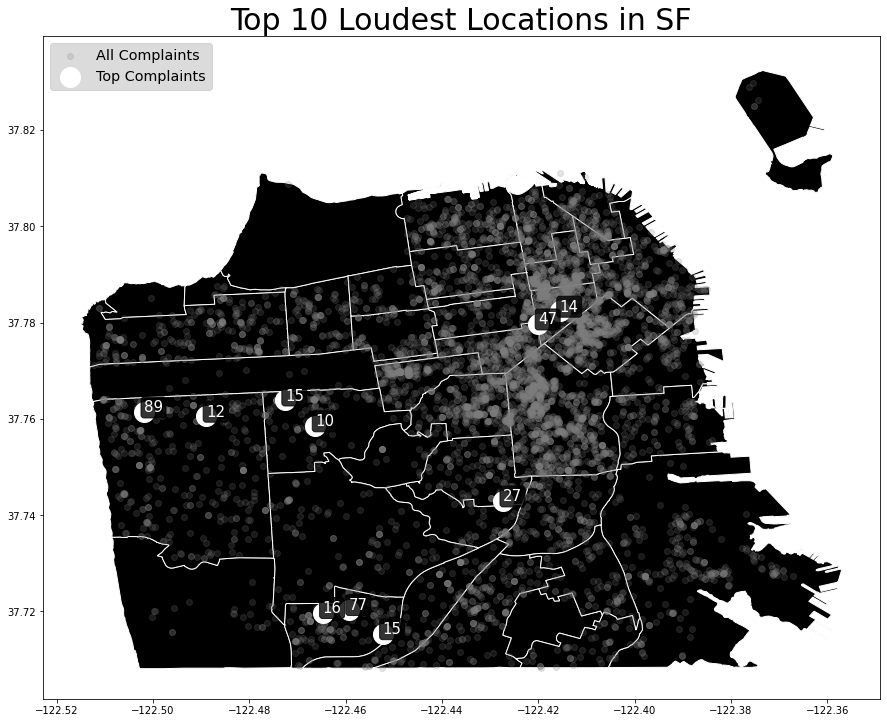

In [73]:
# Mapping the main frame – map of SF neighborhoods
ax = shapes.plot(color='k', edgecolor='white', figsize=(15, 15))
ax.set_facecolor('white')   # sets background to white
ax.set_title('Top 10 Loudest Locations in SF', fontsize=30)


# Mapping data as subplots
comps_gdp.plot(ax=ax, color='grey', alpha=0.2)   # all complaints layer
complaints = top_noises_gdp.plot(ax=ax, color='white', markersize = 400)   # top complaints layer
complaints.legend(('All Complaints', 'Top Complaints', 'Permits'), loc='upper left', 
                           fontsize = 'x-large', facecolor = 'lightgrey')   # legend

# Generating labels
def annotate_map(count, longitude, latitude):
    complaints.annotate(
            count, xy=(longitude, 
                              latitude),
            color='white',
            fontsize = 15,
            bbox=bbox_props   # sets round boxes around text
        )

for i, row in top_noises.iterrows():
    annotate_map(row['CaseID'], row['Longitude'], row['Latitude'])
    
# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/top_mapped')
    
plt.show()

#### Noise permit data analysis

Finally, we read in the Noise Permits data as above, converting coordinates into actionable geospatial objects.

In [97]:
noise_permits = pd.read_csv(os.path.join(rawdata_dir, 'Night_Noise_Permits.csv'))

def point_from_str_rev(location):
    lat, lon = map(float, re.findall(r'(-?\d+\.\d+)', location))
    return (lat, lon)

# Create a coordinates column with proper lon/lat tuples
noise_permits['coordinates'] = noise_permits.point.apply(point_from_str_rev)
# Convert to Geopandas Points
noise_permits['coordinates'] = noise_permits['coordinates'].apply(Point)
noise_permits_gdp = gdp.GeoDataFrame(noise_permits, geometry='coordinates')

Because the Noise Permits data is relatively recent, we filter our complaints data to match its timeframe (2019-08-01 through current) before also converting it GeoPandas. 

In [98]:
start_date = '2019/08/01 00:00:00' # Noise Permits data first occurrence

# Filtering data by date
filter_ = (noise_comps['Opened'] > start_date)
recent_comps = noise_comps.loc[filter_]

In [99]:
# Filtering and counting data
toprecent_noises = recent_comps.groupby(by=['location', 'Address', 'Latitude', 'Longitude']).CaseID.count().reset_index().sort_values(
    by=['CaseID'], ascending=False).head(10)

# Create a coordinates column with proper lon/lat tuples
toprecent_noises['coordinates'] = toprecent_noises.location.apply(point_from_str)
# Convert to Geopandas Points
toprecent_noises['coordinates'] = toprecent_noises['coordinates'].apply(Point)
toprecent_noises_gdp = gdp.GeoDataFrame(toprecent_noises, geometry='coordinates')

toprecent_noises_gdp.head()

,location,Address,Latitude,Longitude,CaseID,coordinates
952,"(37.7797, -122.42)","475 VAN NESS AVE, SAN FRANCISCO, CA, 94102",37.779700,-122.420000,25,POINT (-122.42000 37.77970)
54,"(37.7197876, -122.46476746)","212 GARFIELD ST, SAN FRANCISCO, CA, 94132",37.719788,-122.464767,9,POINT (-122.46477 37.71979)
310,"(37.75368118, -122.4524765)","690 PANORAMA DR, SAN FRANCISCO, CA, 94131",37.753681,-122.452477,8,POINT (-122.45248 37.75368)
139,"(37.730352, -122.436218)","260 THERESA ST, SAN FRANCISCO, CA, 94112",37.730352,-122.436218,7,POINT (-122.43622 37.73035)
103,"(37.72625351, -122.42511749)","100 ATHENS ST, SAN FRANCISCO, CA, 94112",37.726254,-122.425117,6,POINT (-122.42512 37.72625)


**Note:** When merged with noise permit date, the dataframes' coordinates don't match. In other words, it doesn't look like the top 10 loudest locations for 2019-2010 received a night noise permit, although this could be because addresses were entered approximately rather than exactly.

In [21]:
merged = pd.merge(toprecent_noises_gdp, noise_permits, on="coordinates")
merged

,location,Address,Latitude,Longitude,CaseID,coordinates,start_date,end_date,start_end_time_each_day,nnp,...,address,off_hours_contact_name,off_hours_contact_phone,type_of_work,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods


Finally, we build, display and compare the year's top 10 loudest city locations with noise permit locations. We find once again that they do not overlap.

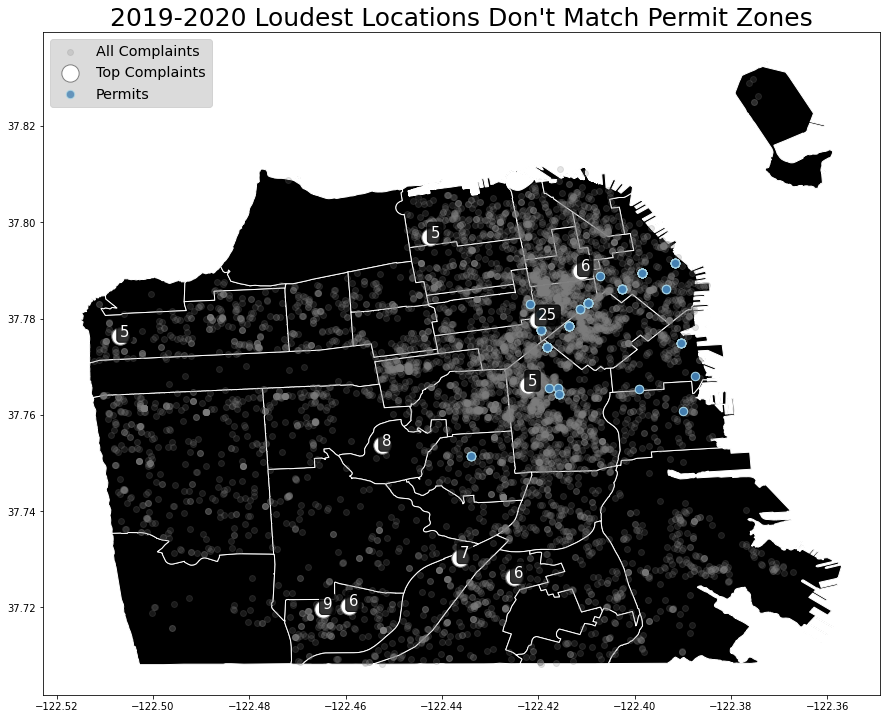

In [22]:
# Mapping the main frame – map of SF neighborhoods
ax = shapes.plot(color='k', edgecolor='white', figsize=(15, 15))
ax.set_facecolor('white')   # sets background to white
plt.title("2019-2020 Loudest Locations Don't Match Permit Zones", fontsize=25)   # sets title

# Mapping data as subplots
base = comps_gdp.plot(ax=ax, color='grey', alpha=0.2)   # all complaints layer
complaints = toprecent_noises_gdp.plot(ax=ax, color='white', edgecolor = 'grey', markersize = 300)   # top complaints layer
permits = noise_permits_gdp.plot(ax=ax, color='steelblue', edgecolor = 'lightblue', 
                                 markersize = 70, alpha = 0.8)   # permits layer
complaints.legend(('All Complaints', 'Top Complaints', 'Permits'), loc='upper left', 
                           fontsize = 'x-large', facecolor = 'lightgrey')   # legend

# Generating labels
for i, row in toprecent_noises.iterrows():
    annotate_map(row['CaseID'], row['Longitude'], row['Latitude'])
    
# Saving graph to data/processed/
plt.savefig(os.getenv('DATA_DIR')+'/processed/top_permits_mapped')

plt.show()